# Exam 07/02/2022
## 1. Load the dataset1.csv and explore the data, showing size, structure
and histograms of numeric data; show the histogram of the frequencies
of the class labels, contained in the “y” column

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits import mplot3d

random_state = 42

In [42]:
df=pd.read_csv("exam_superv.csv")
print("dataset shape:", df.shape)
print("Head:")
df.head()

dataset shape: (1200, 4)
Head:


,0,1,y,2
0,1.589942,2.977770,0,1.953805
1,2.908437,1.837522,1,1.510049
2,3.284091,1.818476,1,3.307287
3,3.148717,2.071991,1,3.452021
4,2.116881,2.133874,0,2.157870


histogram of numerical features


array([[<AxesSubplot: title={'center': '0'}>,
        <AxesSubplot: title={'center': '1'}>],
       [<AxesSubplot: title={'center': '2'}>, <AxesSubplot: >]],
      dtype=object)

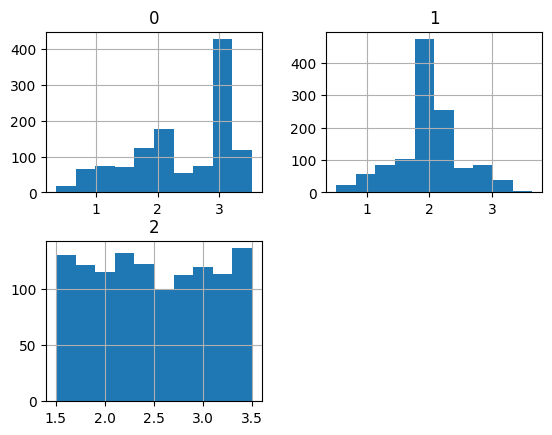

In [43]:
print("histogram of numerical features")
df.drop("y", axis=1).hist()


<AxesSubplot: title={'center': 'histogram of y column'}>

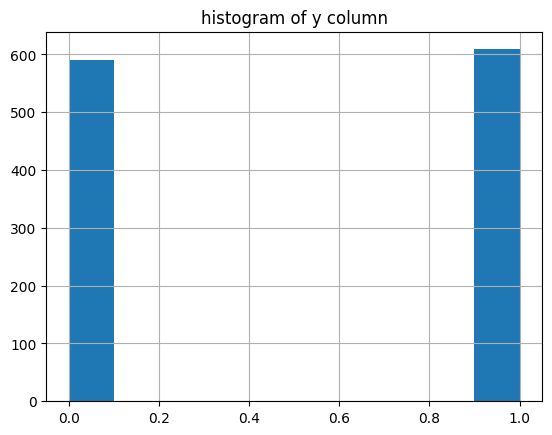

In [44]:
plt.title("histogram of y column")
df["y"].hist()

2. drop the column “y” and find the best clustering scheme and hyper–
parameters able to reproduce the y column (hint: before clustering you
can consider dropping columns with little correlation to “y”; perhaps
you should consider more than one estimator for clustering) 

In [45]:
X=df.drop("y", axis=1)
y=df["y"]
n_clusters=len(np.unique(y))


By looking at the pairplot, it's evident that the 2 most correlated features to y are 0 and 1. We can also use sklearn's feature selection module to be sure

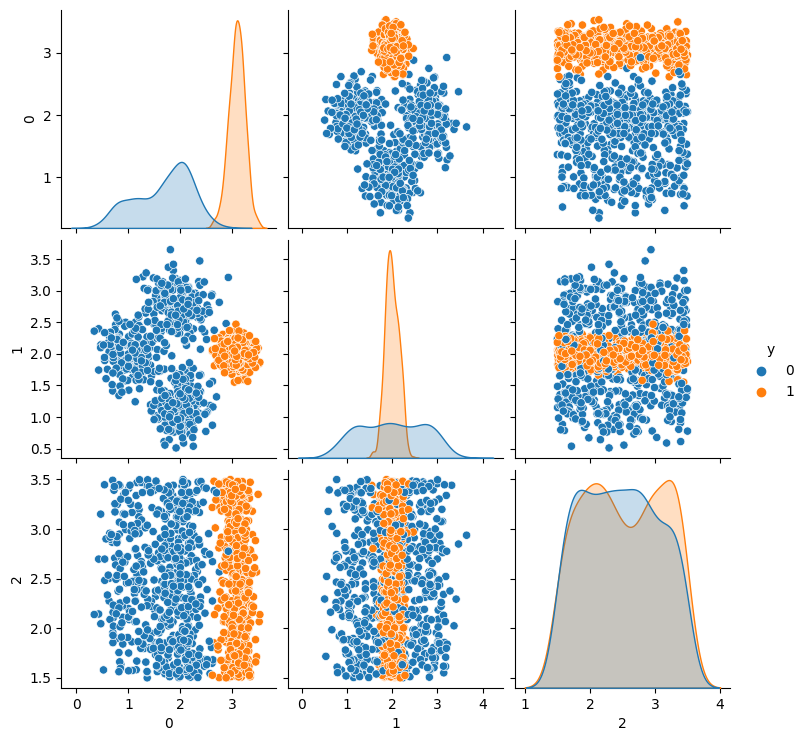

In [46]:
sns.pairplot(df, hue="y")
from sklearn.feature_selection import chi2, SelectKBest
X_new=SelectKBest(score_func=chi2, k=X.shape[1]-1).fit_transform(X,y)
pd.DataFrame(X_new).head()
X=X.drop("2", axis=1)


We will consider K-means and DBSCAN 

In [47]:
#KMEANS
km_model=KMeans(n_clusters=n_clusters,random_state=random_state)
y_km=km_model.fit_predict(X,y)

/home/danielenapo/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


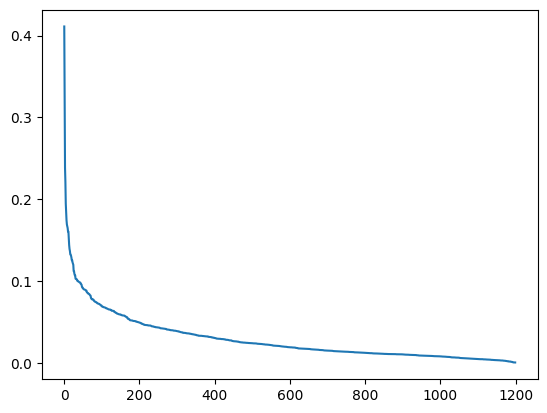

In [48]:
#DBSCAN
#guess minpoints as 2*D (empirical rule)
minPoints=2*X.shape[1]
# get nearest k points
from sklearn.neighbors import NearestNeighbors
k_nearest_neighbors=NearestNeighbors(n_neighbors=minPoints)
k_nearest_neighbors.fit(X)
dist, ind=k_nearest_neighbors.kneighbors(X)
#sort in descending order 
dist = dist[:,1]
dist=np.sort(dist)[::-1]
plt.plot(dist)


epsilon has to be chosen between 0.3 and 0.1 (area in which the slope is most negative)

In [96]:
# import prarameter grid
from sklearn.model_selection import ParameterGrid
# create parameter grid
grid={"eps":np.arange(0.1,0.4,0.01), "min_samples":list(range(minPoints-3,minPoints+3,1))}
param_grid=list(ParameterGrid(grid))
silhoutette_scores=[]
n_clusters=[]
unclust_perc=[]
#iterate over parameter grid and train different DBSCAN models, comparing the silhouette score
for i in range(len(param_grid)):
    model_db=DBSCAN(**param_grid[i])
    y_db = model_db.fit_predict(X)
    cluster_labels_all = np.unique(y_db)
    cluster_labels = cluster_labels_all[cluster_labels_all != -1]
    n_clusters.append(len(cluster_labels))

    silhoutette_scores.append(silhouette_score(X,y_db))
    #find unclustered percentage (outliers over whole dataset)
    unclust_perc.append(np.count_nonzero(y_db==-1)/len(y_db))


In [101]:
# create a dataframe with columns "eps", "minPoints", "silhouette_score", "unclust_perc" and n_clusters
df_scores=pd.DataFrame(param_grid)
df_scores["silhouette_score"]=silhoutette_scores
df_scores["unclust_perc"]=unclust_perc
df_scores["n_cluster"]=n_clusters
# sort the dataframe by silhouette score and by unclust_perc with a threshold of 0.5 for silhouette
silhouette_thresh=0.5
df_scores=df_scores[df_scores["silhouette_score"]>silhouette_thresh]
df_scores.sort_values(by= ["unclust_perc", "silhouette_score"], ascending=[True, False], inplace=True)
df_scores.head()
#



,eps,min_samples,silhouette_score,unclust_perc,n_cluster
51,0.18,4,0.510283,0.010833,2
52,0.18,5,0.514710,0.012500,2
45,0.17,4,0.509458,0.013333,2
59,0.19,6,0.509608,0.014167,2
46,0.17,5,0.502192,0.016667,2


cluster labels: [-1  0  1]


Text(0.5, 1.0, 'DBSCAN')

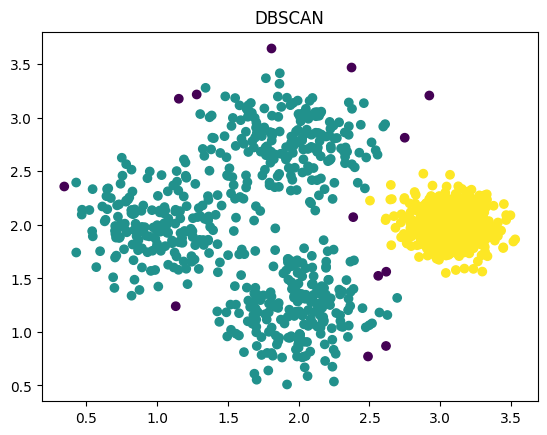

In [102]:
final_model_db=DBSCAN(eps=df_scores.iloc[0,0], min_samples=df_scores.iloc[0,1])
y_db = final_model_db.fit_predict(X)
cluster_labels_all = np.unique(y_db)
print("cluster labels:", cluster_labels_all)
# plot data with cloloured clusters
fig = plt.figure()
plt.scatter(X["0"],X["1"], c=y_db)
plt.title("DBSCAN")


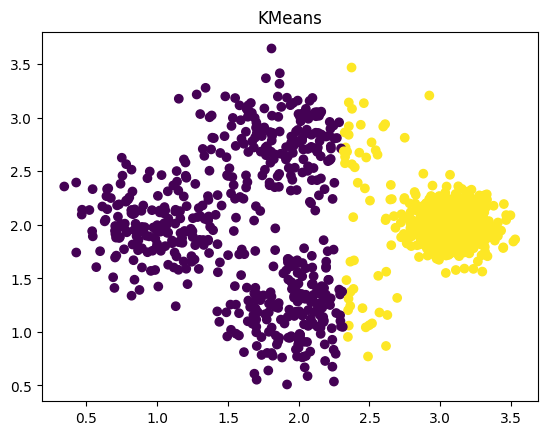

In [107]:
plt.title("KMeans")
plt.scatter(X["0"], X["1"], c=y_km)

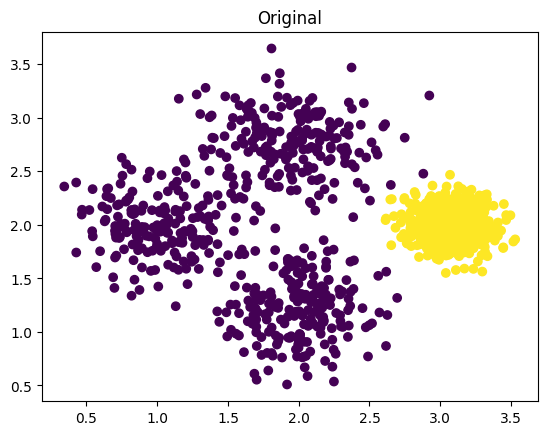

In [108]:
plt.title("Original")
plt.scatter(X["0"], X["1"], c=y)

In [112]:
#print accuracies comparing to gold standard y
from sklearn.metrics import accuracy_score
acc_km=accuracy_score(y_km, y)
acc_db=accuracy_score(y_db, y)
print("accuracy kmeans", acc_km)
print("accuracy dbscan", acc_db)

accuracy kmeans 0.9575
accuracy dbscan 0.9866666666666667
